online keras course : https://www.tensorflow.org/tutorials/images/classification

In [11]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py

Running on localhost
food41.zip: Skipping, found more recently modified local copy (use --force to force download)
Found /food folder already extracted


In [16]:
#Uncomment to select few classes

classes_to_keep = ['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']
if running_on_kaggle:
    for elt in classes_to_keep:
        try:
            shutil.copytree(data_dir + elt,'/kaggle/temp/images_kept/' + elt)
        except:
            print("class ", elt, "already copied !")
    data_dir = '/kaggle/temp/images_kept/'
else:
    for elt in classes_to_keep:
        shutil.copytree(data_dir + elt,'./dataset/food/images_kept/' + elt, dirs_exist_ok=True)
    data_dir = './dataset/food/images_kept/'

In [17]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=batch_size, 
    shuffle=True,
    seed=70,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width))

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']


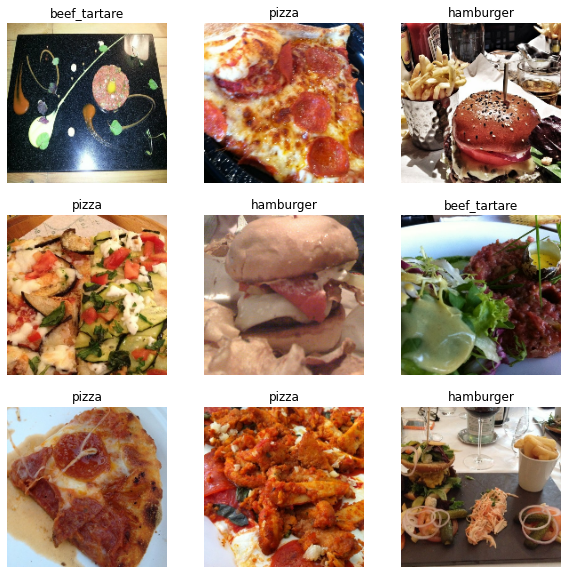

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
# Put the images in RAM, quicker but only works with few images

#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

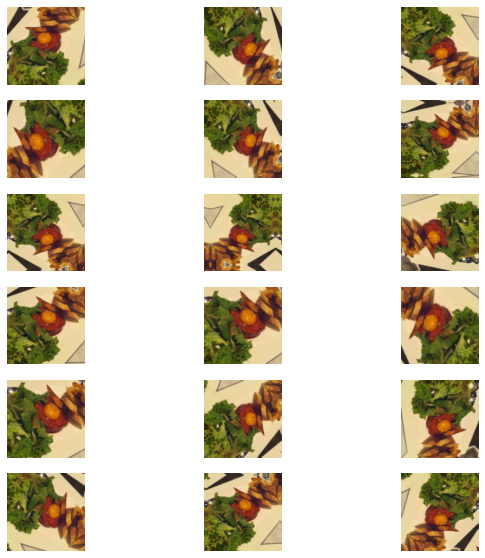

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(18):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Training

In [63]:
num_classes = len(class_names)

inputLayer = layers.Input((180,180,3))
augmentation = data_augmentation(inputLayer)
rescaled = inputLayer/255
for i in range(4):
    layer =  layers.Conv2D(64*(i+1), 3, padding='same', activation='relu',strides=(2,2))(rescaled)
    res_layer = layers.MaxPooling2D()(layer)
    print('a')
    layer = layers.Conv2D(64*(i+1), 3, padding='same', activation='relu')(res_layer)
    layer = layers.Conv2D(64*(i+1), 3, padding='same', activation='relu')(layer)
    res_layer = layers.Add()([layer, res_layer])
    layer = layers.Conv2D(64*(i+1), 3, padding='same', activation='relu')(res_layer)
    layer = layers.Conv2D(64*(i+1), 3, padding='same', activation='relu')(layer)
    res_layer = layers.Add()([layer, res_layer])   
layer = layers.Flatten()(res_layer)
output_layer = layers.Dense(num_classes)(layer)

model = keras.models.Model(inputs = [inputLayer], outputs = [output_layer])


a
a
a
a


In [64]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_7 (TFOpLambda)  (None, 180, 180, 3)  0          ['input_8[0][0]']                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 90, 90, 256)  7168        ['tf.math.truediv_7[0][0]']      
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 45, 45, 256)  0          ['conv2d_106[0][0]']       

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_7 (TFOpLambda)  (None, 180, 180, 3)  0          ['input_8[0][0]']                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 90, 90, 256)  7168        ['tf.math.truediv_7[0][0]']      
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 45, 45, 256)  0          ['conv2d_106[0][0]']       

In [67]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
100/100 [==============================] - 1014s 10s/step - loss: 2.3289 - accuracy: 0.3316 - val_loss: 1.3079 - val_accuracy: 0.3750
Epoch 2/10
 22/100 [=====>........................] - ETA: 11:46 - loss: 1.2851 - accuracy: 0.4190

KeyboardInterrupt: 

In [23]:
if running_on_kaggle:
    model.save('/kaggle/working/saved_model/')
    shutil.make_archive('/kaggle/working/saved_model', 'zip', '/kaggle/working/')
else:
    model.save('./saved_model/')

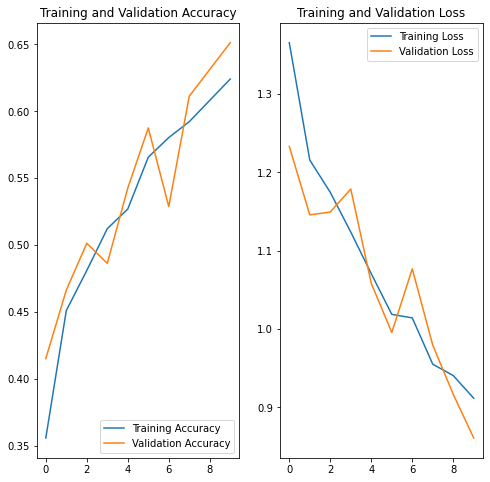

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Unseen data prediction

In [41]:
pizza_url = "https://img.cuisineaz.com/660x660/2021/02/25/i159373-pizza-margherita.jpeg"
pizza_path = tf.keras.utils.get_file('pizza', origin=pizza_url)

img = tf.keras.utils.load_img(
    pizza_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

212992/202559 [===============================] - 0s 0us/step
This image most likely belongs to pizza with a 98.04 percent confidence.


In [45]:
train_ds.__dict__

{'_input_dataset': <PrefetchDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int32)>,
 '_batch_size': <tf.Tensor: shape=(), dtype=int64, numpy=32>,
 '_drop_remainder': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 '_structure': (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 '_metadata': ,
 '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<BatchDatasetV2Op(32)::Dataset>>,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name='_variant_tracker', ref=<tensorflow.python.data.ops.dataset_ops._VariantTracker object at 0x00000264E0831CD0>)],
 '_self_unconditional_dependency_names': {'_variant_tracker': <tensorflow.python.data.ops.dataset_ops._VariantTracker at 0x264e0831cd0>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_va